In [1]:
#| hide

# This cell will not be rendered but is to hide warnings

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('statsforecast').setLevel(logging.ERROR)

import pandas as pd
pd.set_option('display.max_rows', 6)

# ARCH Model

> Step-by-step guide on using the `ARCH Model` with `Statsforecast`.

In this walkthrough, we will become familiar with the main `StatsForecast` class and some relevant methods such as `StatsForecast.plot`, `StatsForecast.forecast` and `StatsForecast.cross_validation`.

## Table of Contents

* [Introduction](#introduction)
* [ARCH Models](#model)
* [Loading libraries and data](#loading)
* [Explore data with the plot method](#plotting)
* [Split the data into training and testing](#splitting)
* [Implementation of ARCH with StatsForecast](#implementation)
* [Cross-validation](#cross_validate)
* [Model evaluation](#evaluate)
* [References](#references)

## Introduction <a class="anchor" id="introduction"></a>

Financial time series analysis has been one of the hottest research topics in the recent decades. In this guide, we illustrate the stylized facts of financial time series by real financial data. To characterize these facts, new models different from the Box- Jenkins ones are needed. And for this reason, ARCH models were firstly proposed by R. F. Engle in 1982 and have been extended by a great number of scholars since then. We also demonstrate how to use Python and its libraries to implement `ARCH`.

As we have known, there are  lot of time series that possess the ARCH effect, that is, although the (modeling residual) series is white noise, its squared series may be autocorrelated. What is more, in practice, a large number of financial time series are found having this property so that the ARCH effect has become one of the stylized facts from financial time series.

### Stylized Facts of Financial Time Series
Now we briefly list and describe several important stylized facts (features) of financial return series:

* **Fat (heavy) tails:** The distribution density function of returns often has fatter (heavier) tails than the tails of the corresponding normal distribution density. 

* **ARCH effect:** Although the return series can often be seen as a white noise, its squared (and absolute) series may usually be autocorrelated, and these autocorrelations are hardly negative. 

* **Volatility clustering:** Large changes in returns tend to cluster in time, and small changes tend to be followed by small changes.

* **Asymmetry:** As we have know , the distribution of asset returns is slightly negatively skewed. One possible explanation could be that traders react more strongly to unfavorable information than favorable information.

## Definition of Arch Models <a class="anchor" id="model"></a>

Specifically, we give the definition of the ARCH model as follows. 

**Definition 1.**  An $\text{ARCH(p)}$ model with order $p≥1$ is ofthe form

\begin{equation}
    \left\{
	    \begin{array}{ll}
		 X_t =\sigma_t \varepsilon_t      \\
		 \sigma_{t}^2 =\omega+ \alpha_1 X_{t-1}^2 + \alpha_2 X_{t-2}^2  + \cdots+  \alpha_p X_{t-p}^2  \\
	    \end{array}
	\right.
\end{equation}

where $\omega ≥ 0, \alpha_i ≥ 0$, and $\alpha_p > 0$ are constants, $\varepsilon_t \sim iid(0, 1)$, and $\varepsilon_t$ is independent of $\{X_k;k ≤ t − 1 \}$. A stochastic process $X_t$ is called an $ARCH(p)$ process if it satisfies Eq. (1).

By Definition 1, $\sigma_{t}^2$ (and $\sigma_t$ ) is independent of $\varepsilon_t$ . Besides, usually it is further assumed that $\varepsilon_t \sim N(0, 1)$. Sometimes, however, we need to further suppose that $\varepsilon_t$ follows a standardized (skew) Student’s T distribution or a generalized error distribution in order to capture more features of a financial time series.

Let $\mathscr{F}_s$ denote the information set generated by $\{X_k;k ≤ s \}$, namely, the sigma field $\sigma(X_k;k ≤ s)$. It is easy to see that $\mathscr{F}_s$ is independent of $\varepsilon_t$ for any $s <t$. According to Definition 1 and the properties of the conditional mathematical
expectation, we have that

$$E(X_t|\mathscr{F}_{t−1}) = E(\sigma_t \varepsilon_t|\mathscr{F}_{t−1}) = \sigma_t E( \varepsilon_t|\mathscr{F}_{t−1}) = \sigma_t E(\varepsilon_t) = 0 \tag 2$$

and

$$ \text{Var}(X_{t}^2| \mathscr{F}_{t−1}) = E(X_{t}^2|\mathscr{F}_{t−1}) =  E(\sigma_{t}^2 \varepsilon_{t}^2|\mathscr{F}_{t−1}) = \sigma_{t}^2 E(\varepsilon_{t}^2|\mathscr{F}_{t−1}) = \sigma_{t}^2 E(\varepsilon_{t}^2) = \sigma_{t}^2. $$

This implies that $\sigma_{t}^2$ is the conditional variance of $X_t$ and it evolves according to the previous values of $\{X_{k}^2; t −p ≤ k ≤ t −1\}$ like an $\text{AR}(p)$ model. And so Model (1) is named an $\text{ARCH}(p)$ model.


As an example of $\text{ARCH}(p)$ models, let us consider the $\text{ARCH(1)}$ model

\begin{equation}
    \left\{ 
	    \begin{array}{ll} \tag 3
		 X_t =\sigma_t \varepsilon_t      \\
		 \sigma_{t}^2 =\omega+ \alpha_1 X_{t-1}^2   \\
	    \end{array}
	\right.
\end{equation}

Explicitly, the unconditional mean
$$E(X_t) = E(\sigma_t \varepsilon_t) = E(\sigma_t) E(\varepsilon_t) = 0. $$

Additionally, the ARCH(1) model can be expressed as

$$X_{t}^2 =\sigma_{t}^2 +X_{t}^2 − \sigma_{t}^2  =\omega +\alpha_1 X_{t-1}^2 +\sigma_{t}^2 \varepsilon_{t}^2 −\sigma_{t}^2  =\omega +\alpha_1 X_{t}^2 +\eta_t ,$$

that is,
$$X_{t}^2 =\omega +\alpha_1 X_{t}^2 +\eta_t \tag 4 $$

where $\eta_t = \sigma_{t}^2(\varepsilon_{t}^2 − 1)$. It can been shown that $\eta_t$ is a new white noise, which is left as an exercise for reader. Hence, if $0 < \alpha_1 < 1$, Eq. (4) is a stationary $\text{AR(1)}$ model for the series Xt2. Thus, the unconditional variance

$$Var ( X_t ) = E( X_{t}^2 ) = E(\omega+ \alpha_1 X_{t-1}^2 + \eta_t ) = \omega+ \alpha_1 E( X_{t}^2 ) ,$$ 

that is,
$$Var (X_t) = E (X_{t}^2 ) =\frac{\omega}{1-\alpha_1}$$

Moreover, for $h > 0$, in light of the properties of the conditional mathematical expectation and by (2), we have that

$$E(X_{t+h} X_t) = E(E(X_{t+h} X_t|\mathscr{F}_{t+h-1})) = E(X_t E(X_{t+h}|\mathscr{F}_{t+h-1})) = 0.$$

In conclusion, if $0 < \alpha_1 < 1$, we have that:

* Any $\text{ARCH}(1)$ process $\{X_t \}$ defined by Eqs.(3) follows a white noise $WN(0, \omega/(1 − \alpha_1))$ .

* Since $X_{t}^2$ is an $\text{AR}(1)$ process defined by (4), $\text{Corr}(X_{t}^2,X_{t+h}^2) = \alpha_{1}^{|h|} > 0$, which reveals the ARCH effect.

* It is clear that $E(\eta_t|\mathscr{F}_s)=0$ for any $t>s$,and with Eq.(4),for any $k>1$:
$$Var(X_{t+k} |\mathscr{F}_t ) = E(X_{t+K}^2 |\mathscr{F}_t)$$
$$= E(\omega + \alpha_1 X_{t+k-1}+ \eta_{t+k}|\mathscr{F}_t )$$
$$= \omega + \alpha_1 Var(X_{t+k−1}|\mathscr{F}_t),$$

which reflects the volatility clustering, that is, large (small) volatility is followed by large (small) one.

In addition, we are able to prove that Xt defined by Eq. (3) has heavier tails than the corresponding normal distribution. At last, note that these properties of the ARCH(1) model can be generalized to ARCH(p) models.

### Advantages and disadvantages of the Autoregressive Conditional Heteroskedasticity (ARCH) model:

|Advantages|Disadvantages|
|----------|-------------|
|- The ARCH model is useful for modeling volatility in financial time series, which is important for investment decision making and risk management.|- The ARCH model assumes that the forecast errors are independent and identically distributed, which may not be realistic in some cases.|
|- The ARCH model takes heteroscedasticity into account, which means that it can model time series with variances that change over time.|- The ARCH model can be difficult to fit to data with many parameters, which may require large amounts of data or advanced estimation techniques.|
|- The ARCH model is relatively easy to use and can be implemented with standard econometrics software.|- The ARCH model does not take into account the possible relationship between the mean and the variance of the time series, which may be important in some cases.|

Note:

The ARCH model is a useful tool for modeling volatility in financial time series, but like any econometric model, it has limitations and should be used with caution depending on the specific characteristics of the data being modeled.








### Autoregressive Conditional Heteroskedasticity (ARCH) Applications

* **Finance** – The ARCH model is widely used in finance to model volatility in financial time series, such as stock prices, exchange rates, interest rates, etc.

* **Economics** - The ARCH model can be used to model volatility in economic data, such as GDP, inflation, unemployment, among others.

* **Engineering** - The ARCH model can be used in engineering to model volatility in data related to energy, climate, pollution, industrial production, among others.

* **Social Sciences** - The ARCH model can be used in the social sciences to model volatility in data related to demography, health, education, among others.

* **Biology** - The ARCH model can be used in biology to model volatility in data related to evolution, genetics, epidemiology, among others.

## Loading libraries and data <a class="anchor" id="loading"></a>

:::{.callout-tip} Statsforecast will be needed. To install, see [instructions](../getting-started/Installation.ipynb). :::

Next, we import plotting libraries and configure the plotting style.

In [2]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (18,7)

### Read Data

Let's pull the S&P500 stock data from the Yahoo Finance site.

In [3]:
import pandas as pd
import time
from datetime import datetime

ticker = '^GSPC'
period1 = int(time.mktime(datetime(2015, 1, 1, 23, 59).timetuple()))
period2 = int(time.mktime(datetime.now().timetuple()))
interval = '1d' # 1d, 1m

query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'

SP_500 = pd.read_csv(query_string)
SP_500.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,2058.899902,2072.360107,2046.040039,2058.199951,2058.199951,2708700000
1,2015-01-05,2054.439941,2054.439941,2017.339966,2020.579956,2020.579956,3799120000
2,2015-01-06,2022.150024,2030.250000,1992.439941,2002.609985,2002.609985,4460110000
3,2015-01-07,2005.550049,2029.609985,2005.550049,2025.900024,2025.900024,3805480000
4,2015-01-08,2030.609985,2064.080078,2030.609985,2062.139893,2062.139893,3934010000


In [4]:
df=SP_500[["Date","Close"]]

The input to StatsForecast is always a data frame in long format with three columns: unique_id, ds and y:

* The `unique_id` (string, int or category) represents an identifier for the series.

* The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast.

In [5]:
df["unique_id"]="1"
df.columns=["ds", "y", "unique_id"]
df.head()

,ds,y,unique_id
0,2015-01-02,2058.199951,1
1,2015-01-05,2020.579956,1
2,2015-01-06,2002.609985,1
3,2015-01-07,2025.900024,1
4,2015-01-08,2062.139893,1


In [6]:
print(df.dtypes)

ds            object
y            float64
unique_id     object
dtype: object


We need to convert the `object` type to datetime.

In [7]:
df["ds"] = pd.to_datetime(df["ds"])

## Explore data with the plot method <a class="anchor" id="plotting"></a>

Plot a series using the plot method from the StatsForecast class. This method prints a random series from the dataset and is useful for basic EDA.

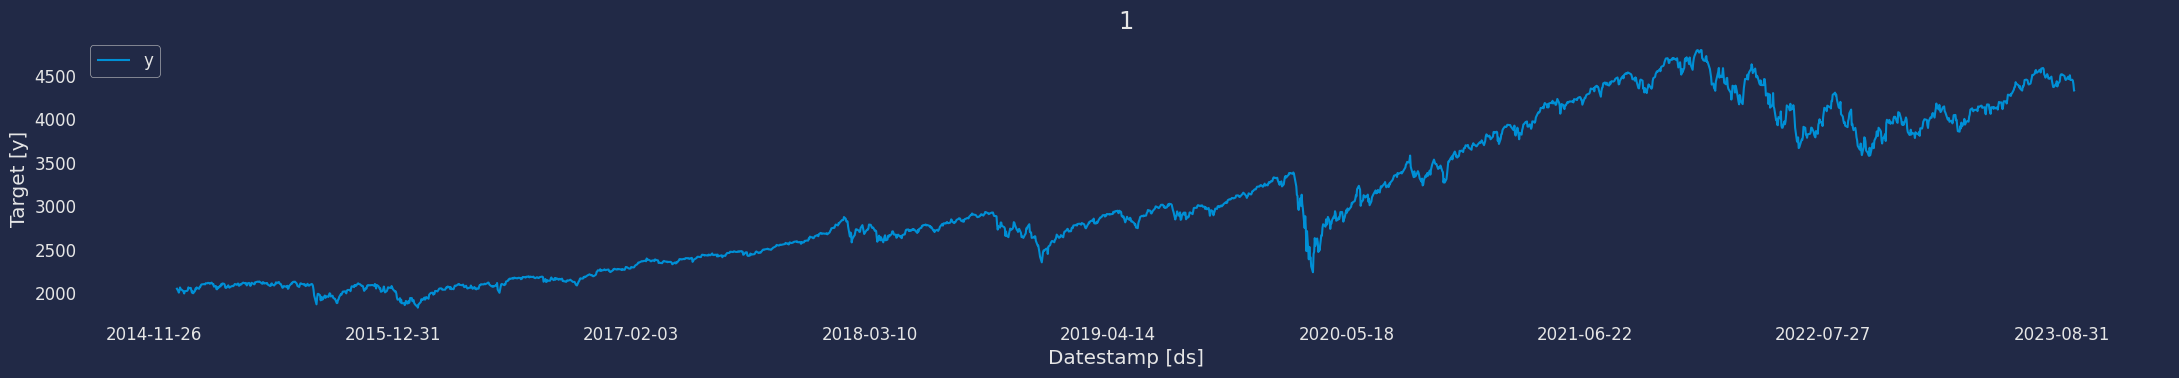

In [8]:
from statsforecast import StatsForecast

StatsForecast.plot(df)

### The Augmented Dickey-Fuller Test

An Augmented Dickey-Fuller (ADF) test is a type of statistical test that determines whether a unit root is present in time series data. Unit roots can cause unpredictable results in time series analysis. A null hypothesis is formed in the unit root test to determine how strongly time series data is affected by a trend. By accepting the null hypothesis, we accept the evidence that the time series data is not stationary. By rejecting the null hypothesis or accepting the alternative hypothesis, we accept the evidence that the time series data is generated by a stationary process. This process is also known as stationary trend. The values of the ADF test statistic are negative. Lower ADF values indicate a stronger rejection of the null hypothesis.

Augmented Dickey-Fuller Test is a common statistical test used to test whether a given time series is stationary or not. We can achieve this by defining the null and alternate hypothesis.

Null Hypothesis: Time Series is non-stationary. It gives a time-dependent trend.
Alternate Hypothesis: Time Series is stationary. In another term, the series doesn’t depend on time.

ADF or t Statistic < critical values: Reject the null hypothesis, time series is stationary.
ADF or t Statistic > critical values: Failed to reject the null hypothesis, time series is non-stationary.

Let's check if our series that we are analyzing is a stationary series. Let's create a function to check, using the `Dickey Fuller` test

In [9]:
from statsmodels.tsa.stattools import adfuller

def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Dickey-Fuller test results for columns: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of observations used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("The data is stationary")
    else:
        print("Conclusion:====>")
        print("The null hypothesis cannot be rejected")
        print("The data is not stationary")

In [10]:
Augmented_Dickey_Fuller_Test_func(df["y"],'S&P500')

Dickey-Fuller test results for columns: S&P500
Test Statistic          -0.787511
p-value                  0.822763
No Lags Used            10.000000
                          ...    
Critical Value (1%)     -3.433346
Critical Value (5%)     -2.862864
Critical Value (10%)    -2.567475
Length: 7, dtype: float64
Conclusion:====>
The null hypothesis cannot be rejected
The data is not stationary


In the previous result we can see that the `Augmented_Dickey_Fuller` test gives us a `p-value` of 0.864700, which tells us that the null hypothesis cannot be rejected, and on the other hand the data of our series are not stationary.

We need to differentiate our time series, in order to convert the data to stationary.

### Return Series

Since the 1970s, the financial industry has been very prosperous with advancement of computer and Internet technology. Trade of financial products (including various derivatives) generates a huge amount of data which form financial time series. For finance, the return on a financial product is most interesting, and so our attention focuses on the return series. If {Pt } is the closing price at time t for a certain financial product, then the return on this product is

$$X_t = \frac{(P_t − P_{t−1})}{P_{t−1}} ≈ log(P_t ) − log(P_{t−1}).$$

It is return series $\{X_t \}$ that have been much independently studied. And important stylized features which are common across many instruments, markets, and time periods have been summarized. Note that if you purchase the financial product, then it becomes your asset, and its returns become your asset returns. Now let us look at the following examples.

We can estimate the series of returns using the [pandas](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pct_change.html), `DataFrame.pct_change()` function. The `pct_change()` function has a periods parameter whose default value is 1. If you want to calculate a 30-day return, you must change the value to 30.

In [11]:
df['return'] = 100 * df["y"].pct_change()
df.dropna(inplace=True, how='any')
df.head()

,ds,y,unique_id,return
1,2015-01-05,2020.579956,1,-1.827811
2,2015-01-06,2002.609985,1,-0.889347
3,2015-01-07,2025.900024,1,1.162984
4,2015-01-08,2062.139893,1,1.788828
5,2015-01-09,2044.810059,1,-0.840381


In [12]:
import plotly.express as px
fig = px.line(df, x=df["ds"], y="return",title="SP500 Return Chart",template = "plotly_dark")
fig.show()

### Creating Squared Returns

In [13]:
df['sq_return'] = df["return"].mul(df["return"])
df.head()

,ds,y,unique_id,return,sq_return
1,2015-01-05,2020.579956,1,-1.827811,3.340891
2,2015-01-06,2002.609985,1,-0.889347,0.790938
3,2015-01-07,2025.900024,1,1.162984,1.352532
4,2015-01-08,2062.139893,1,1.788828,3.199906
5,2015-01-09,2044.810059,1,-0.840381,0.706240


### Returns vs Squared Returns

In [14]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2)

fig.add_trace(go.Scatter(x=df["ds"], y=df["return"],
                         mode='lines',
                         name='return'),
row=1, col=1
)


fig.add_trace(go.Scatter(x=df["ds"], y=df["sq_return"],
                         mode='lines',
                         name='sq_return'), 
    row=1, col=2
)

fig.update_layout(height=600, width=800, title_text="Returns vs Squared Returns", template = "plotly_dark")
fig.show()

In [15]:
from scipy.stats import probplot, moment
from statsmodels.tsa.stattools import adfuller, q_stat, acf
import numpy as np
import seaborn as sns

def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Return')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title+ f'Dickey-Fuller: {adfuller(x)[1]:>11.2f}', fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

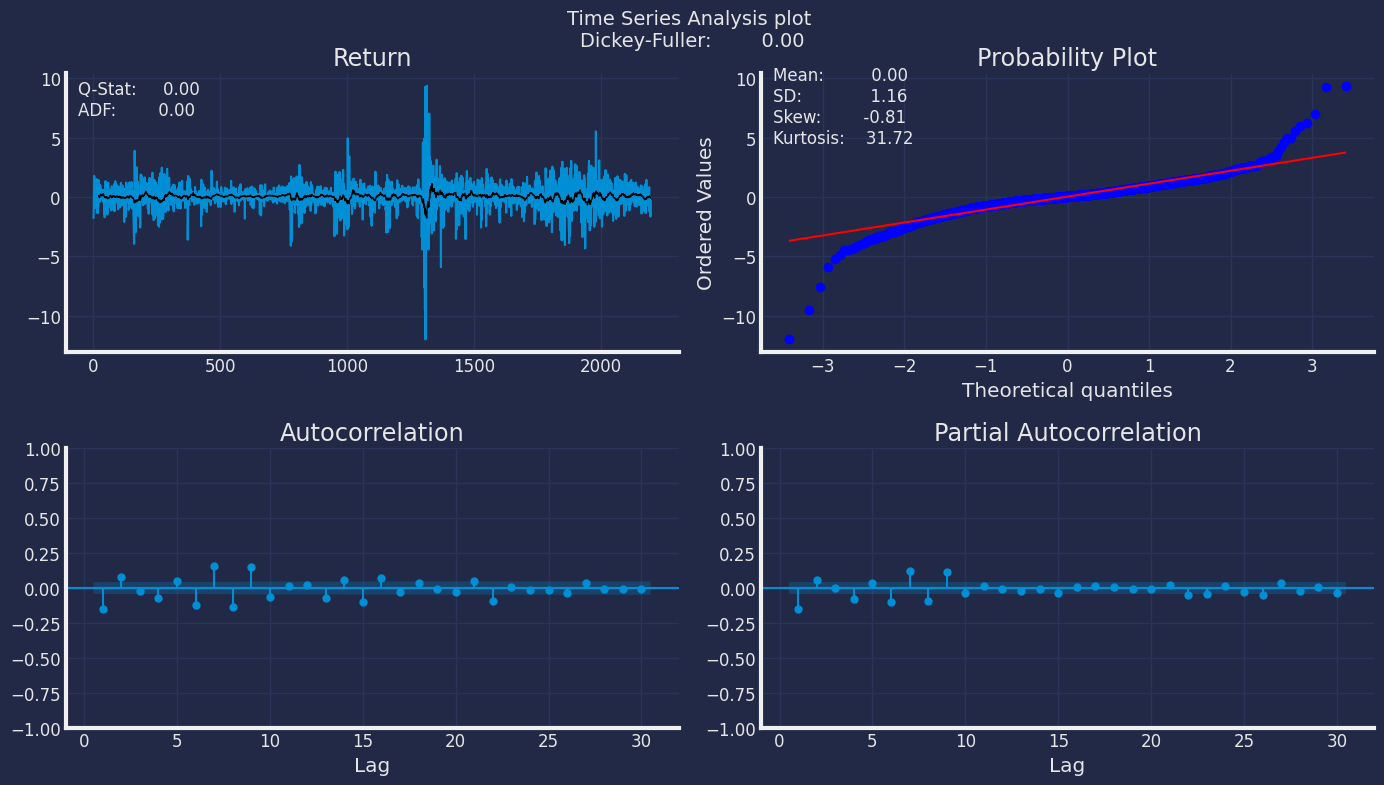

In [16]:
plot_correlogram(df["return"], lags=30, title="Time Series Analysis plot \n") 

### Ljung-Box Test

Ljung-Box is a test for autocorrelation that we can use in tandem with our ACF and PACF plots. The Ljung-Box test takes our data, optionally either lag values to test, or the largest lag value to consider, and whether to compute the Box-Pierce statistic. Ljung-Box and Box-Pierce are two similar test statisitcs,  Q , that are compared against a chi-squared distribution to determine if the series is white noise. We might use the Ljung-Box test on the residuals of our model to look for autocorrelation, ideally our residuals would be white noise.

- Ho : The data are independently distributed, no autocorrelation.
- Ha : The data are not independently distributed; they exhibit serial correlation.

The Ljung-Box with the Box-Pierce option will return, for each lag, the Ljung-Box test statistic, Ljung-Box p-values, Box-Pierce test statistic, and Box-Pierce p-values.

If  $p<\alpha  (0.05)$ we reject the null hypothesis.

In [17]:
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_res = acorr_ljungbox(df["return"], lags= 40, boxpierce=True)

ljung_res.head()

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,49.084018,2.452302e-12,49.016994,2.537545e-12
2,62.974905,2.114331e-14,62.882591,2.214211e-14
3,64.003767,8.192843e-14,63.909110,8.583753e-14
4,74.532698,2.501770e-15,74.409287,2.656714e-15
5,80.462889,6.714400e-16,80.320584,7.190906e-16


## Split the data into training and testing<a class="anchor" id="splitting"></a>

Let's divide our data into sets

1. Data to train our `ARCH` model
2. Data to test our model

For the test data we will use the last 30 day to test and evaluate the performance of our model.

In [18]:
df=df[["ds","unique_id","return"]]
df.columns=["ds", "unique_id", "y"]

In [19]:
train = df[df.ds<='2023-05-24'] # Let's forecast the last 30 days
test = df[df.ds>'2023-05-24']

In [20]:
train.shape, test.shape

((2112, 3), (83, 3))

Now let's plot the training data and the test data.

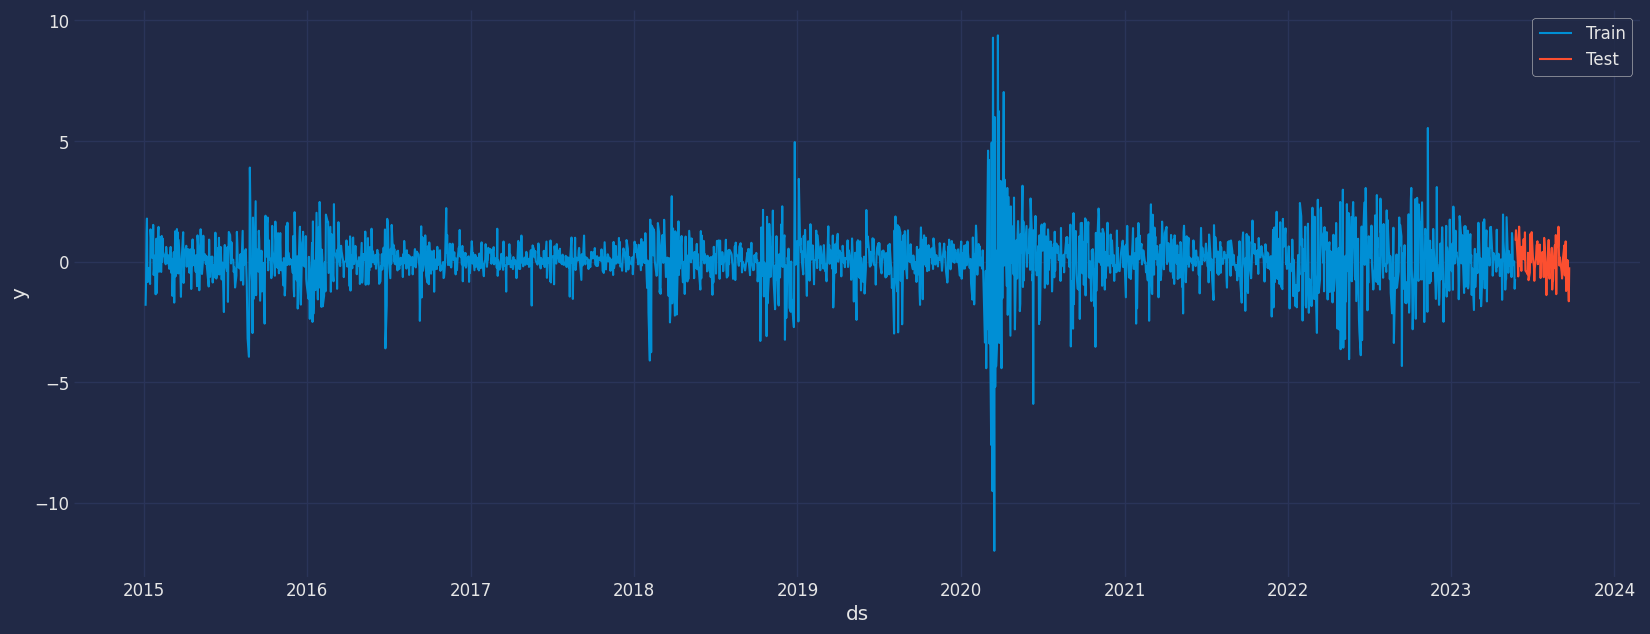

In [21]:
sns.lineplot(train,x="ds", y="y", label="Train")
sns.lineplot(test, x="ds", y="y", label="Test")
plt.show()

## Implementation of ARCH with StatsForecast <a class="anchor" id="implementation"></a>

To also know more about the parameters of the functions of the `ARCH Model`, they are listed below. For more information, visit the [documentation](https://nixtla.github.io/statsforecast/src/core/models.html#arch-model)

```
p : int
    Number of lagged versions of the series.
alias : str
    Custom name of the model.
prediction_intervals : Optional[ConformalIntervals]
    Information to compute conformal prediction intervals.
    By default, the model will compute the native prediction
    intervals.
```

### Load libraries

In [22]:
from statsforecast import StatsForecast 
from statsforecast.models import ARCH 

### Building Model
Import and instantiate the models. Setting the argument is sometimes tricky. This article on [Seasonal periods](https://robjhyndman.com/hyndsight/seasonal-periods/) by the master, Rob Hyndmann, can be useful.season_length.

In [23]:
season_length = 7 # Daily data
horizon = len(test) # number of predictions biasadj=True, include_drift=True,

models = [ARCH(p=2,)]

We fit the models by instantiating a new StatsForecast object with the following parameters:

models: a list of models. Select the models you want from models and import them.

* `freq:` a string indicating the frequency of the data. (See [pandas’ available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).)

* `n_jobs:` n_jobs: int, number of jobs used in the parallel processing, use -1 for all cores.

* `fallback_model:` a model to be used if a model fails.

Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame.

In [24]:
sf = StatsForecast(df=train,
                   models=models,
                   freq='C', # custom business day frequency
                   n_jobs=-1)

### Fit the Model

In [25]:
sf.fit()

StatsForecast(models=[ARCH(2)])

Let's see the results of our ARCH model. We can observe it with the following instruction:

In [26]:
result=sf.fitted_[0,0].model_
result

{'p': 2,
 'q': 0,
 'coeff': array([0.44320919, 0.34706759, 0.35171967]),
 'message': 'Optimization terminated successfully',
 'y_vals': array([-1.12220268, -0.73186004]),
 'sigma2_vals': array([1.38768694,        nan, 1.89277546, ..., 0.76423015, 0.45064543,
        0.88036943]),
 'fitted': array([        nan,         nan,  2.23474473, ..., -1.48032981,
         1.10018826, -0.98050094]),
 'actual_residuals': array([        nan,         nan, -1.07176046, ...,  1.4958333 ,
        -2.22239094,  0.2486409 ])}

Let us now visualize the residuals of our models.

As we can see, the result obtained above has an output in a dictionary, to extract each element from the dictionary we are going to use the `.get()` function to extract the element and then we are going to save it in a `pd.DataFrame()`.

In [27]:
residual=pd.DataFrame(result.get("actual_residuals"), columns=["residual Model"])
residual

,residual Model
0,NaN
1,NaN
2,-1.071760
...,...
2109,1.495833
2110,-2.222391
2111,0.248641


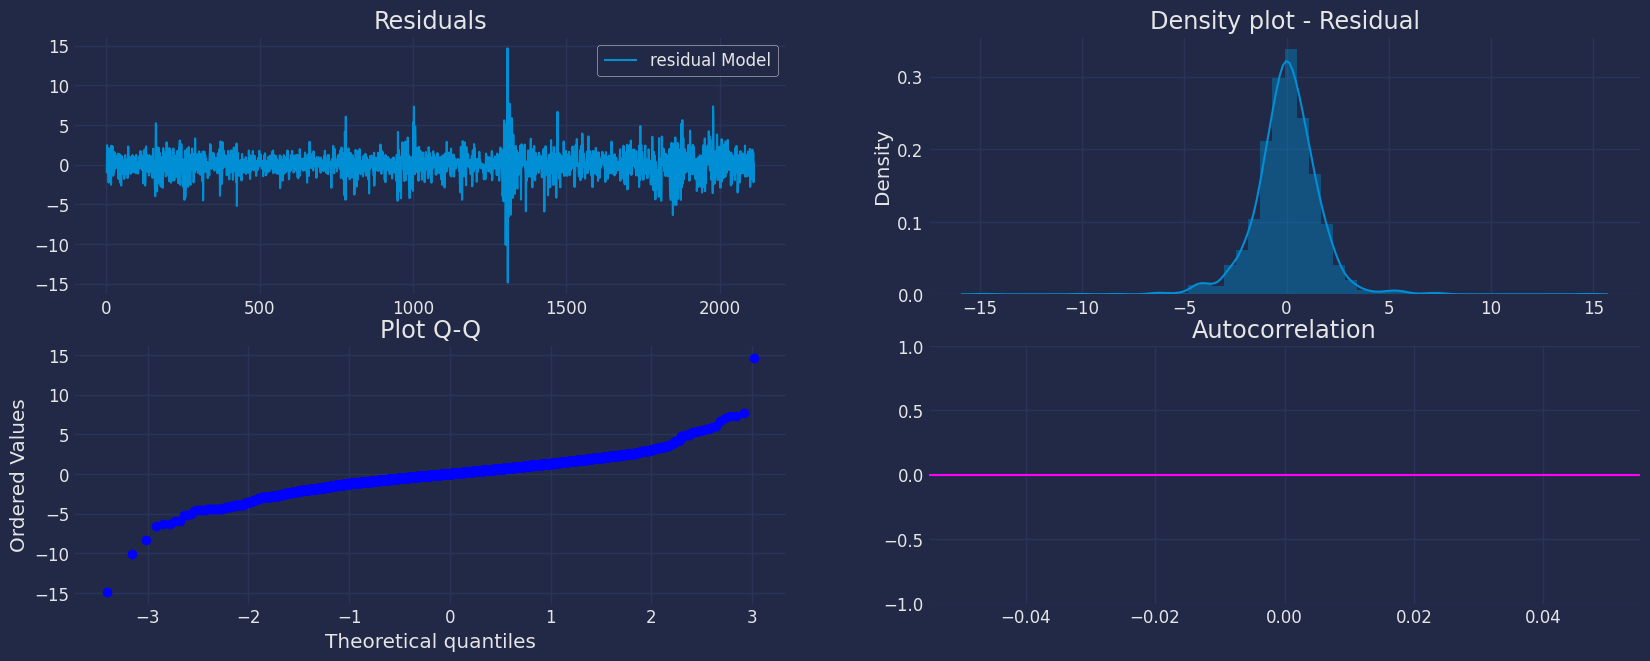

In [28]:
import scipy.stats as stats

fig, axs = plt.subplots(nrows=2, ncols=2)

# plot[1,1]
residual.plot(ax=axs[0,0])
axs[0,0].set_title("Residuals");

# plot
sns.distplot(residual, ax=axs[0,1]);
axs[0,1].set_title("Density plot - Residual");

# plot
stats.probplot(residual["residual Model"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')

# plot
plot_acf(residual,  lags=35, ax=axs[1,1],color="fuchsia")
axs[1,1].set_title("Autocorrelation");

plt.show();

### Forecast Method

If you want to gain speed in productive settings where you have multiple series or models we recommend using the `StatsForecast.forecast` method instead of `.fit` and `.predict`.

The main difference is that the `.forecast` doest not store the fitted values and is highly scalable in distributed environments.

The forecast method takes two arguments: forecasts next `h` (horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 12 months ahead.

* `level (list of floats):` this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, `level=[90]` means that the model expects the real value to be inside that interval 90% of the times.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals. Depending on your computer, this step should take around 1min.

In [29]:
Y_hat = sf.forecast(horizon, fitted=True)

Y_hat

,ds,ARCH(2)
unique_id,,
1,2023-05-25,1.681836
1,2023-05-26,-0.777028
1,2023-05-29,-0.677960
...,...,...
1,2023-09-14,-0.176074
1,2023-09-15,-0.158605
1,2023-09-18,0.126923


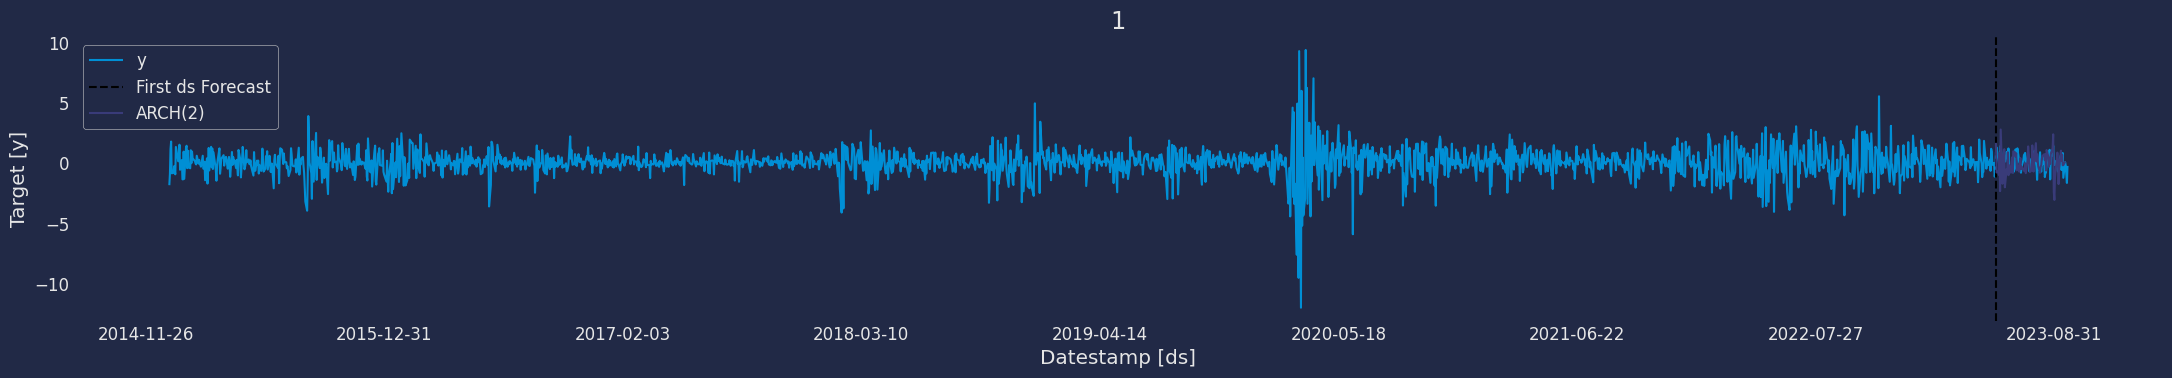

In [30]:
sf.plot(df, Y_hat, level=[95])

In [31]:
values=sf.forecast_fitted_values()
values.head()

,ds,y,ARCH(2)
unique_id,,,
1,2015-01-05,-1.827811,NaN
1,2015-01-06,-0.889347,NaN
1,2015-01-07,1.162984,2.234745
1,2015-01-08,1.788828,-0.667577
1,2015-01-09,-0.840381,-0.752437


Adding 95% confidence interval with the forecast method

In [32]:
sf.forecast(h=horizon, level=[95])

,ds,ARCH(2),ARCH(2)-lo-95,ARCH(2)-hi-95
unique_id,,,,
1,2023-05-25,1.681836,-0.419322,3.782995
1,2023-05-26,-0.777028,-3.939044,2.384989
1,2023-05-29,-0.677960,-3.907244,2.551323
...,...,...,...,...
1,2023-09-14,-0.176074,-1.405353,1.053205
1,2023-09-15,-0.158605,-1.381909,1.064699
1,2023-09-18,0.126923,-0.780235,1.034080


In [33]:
Y_hat=Y_hat.reset_index()
Y_hat

,unique_id,ds,ARCH(2)
0,1,2023-05-25,1.681836
1,1,2023-05-26,-0.777028
2,1,2023-05-29,-0.677960
...,...,...,...
80,1,2023-09-14,-0.176074
81,1,2023-09-15,-0.158605
82,1,2023-09-18,0.126923


In [34]:
# Merge the forecasts with the true values
Y_hat1 = test.merge(Y_hat, how='left', on=['unique_id', 'ds'])
Y_hat1

,ds,unique_id,y,ARCH(2)
0,2023-05-25,1,0.875758,1.681836
1,2023-05-26,1,1.304909,-0.777028
2,2023-05-30,1,0.001660,-0.968701
...,...,...,...,...
80,2023-09-20,1,-0.939479,NaN
81,2023-09-21,1,-1.640093,NaN
82,2023-09-22,1,-0.229560,NaN


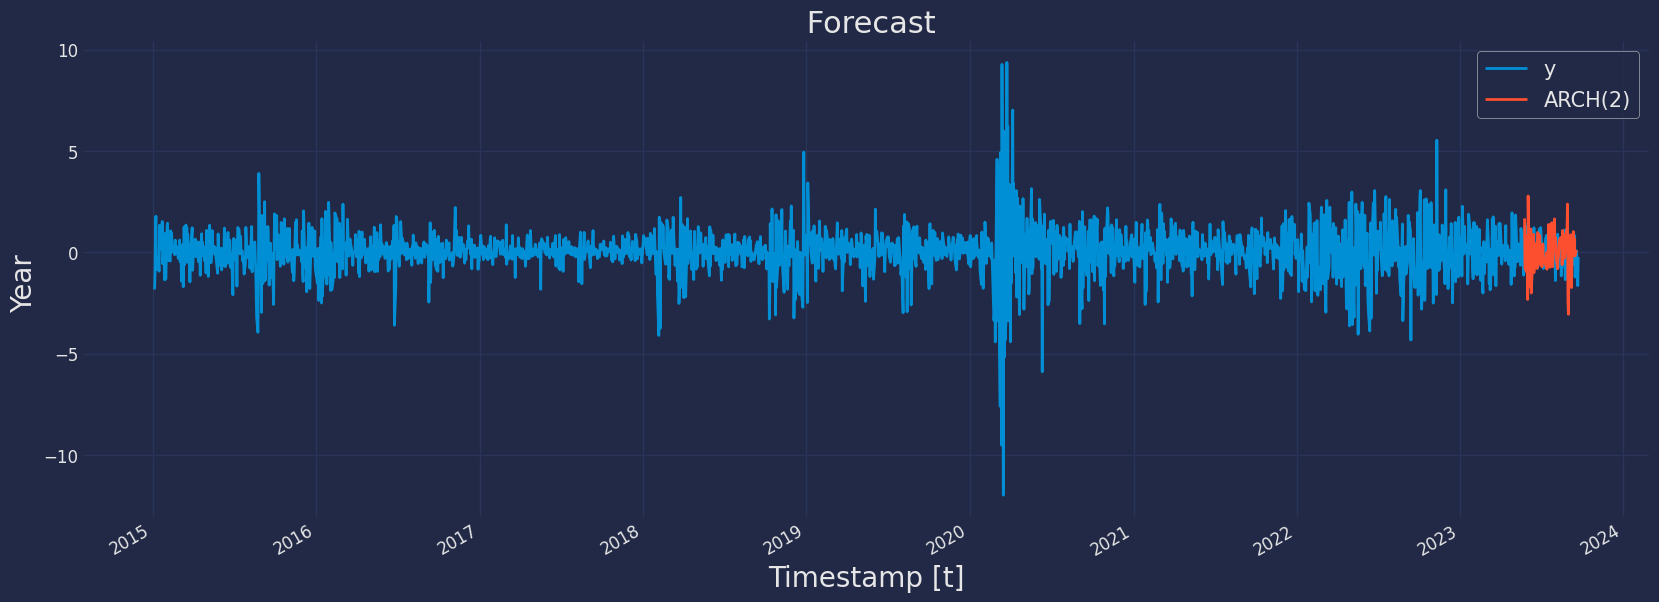

In [35]:
# Merge the forecasts with the true values

fig, ax = plt.subplots(1, 1)
plot_df = pd.concat([train, Y_hat1]).set_index('ds')
plot_df[['y', "ARCH(2)"]].plot(ax=ax, linewidth=2)
ax.set_title(' Forecast', fontsize=22)
ax.set_ylabel('Year ', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid(True)
plt.show()

### Predict method with confidence interval

To generate forecasts use the predict method.

The predict method takes two arguments: forecasts the next `h` (for horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 12 months ahead.

* `level (list of floats):` this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, `level=[95]` means that the model expects the real value to be inside that interval 95% of the times.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals.

This step should take less than 1 second.

In [36]:
sf.predict(h=horizon)

,ds,ARCH(2)
unique_id,,
1,2023-05-25,1.681836
1,2023-05-26,-0.777028
1,2023-05-29,-0.677960
...,...,...
1,2023-09-14,-0.176074
1,2023-09-15,-0.158605
1,2023-09-18,0.126923


In [37]:
forecast_df = sf.predict(h=horizon, level=[80,95]) 

forecast_df

,ds,ARCH(2),ARCH(2)-lo-95,ARCH(2)-lo-80,ARCH(2)-hi-80,ARCH(2)-hi-95
unique_id,,,,,,
1,2023-05-25,1.681836,-0.419322,0.307963,3.055710,3.782995
1,2023-05-26,-0.777028,-3.939044,-2.844559,1.290504,2.384989
1,2023-05-29,-0.677960,-3.907244,-2.789475,1.433555,2.551323
...,...,...,...,...,...,...
1,2023-09-14,-0.176074,-1.405353,-0.979857,0.627708,1.053205
1,2023-09-15,-0.158605,-1.381909,-0.958480,0.641271,1.064699
1,2023-09-18,0.126923,-0.780235,-0.466236,0.720081,1.034080


We can join the forecast result with the historical data using the pandas function `pd.concat()`, and then be able to use this result for graphing.

In [38]:
df_plot=pd.concat([df, forecast_df]).set_index('ds').tail(220)
df_plot

,unique_id,y,ARCH(2),ARCH(2)-lo-95,ARCH(2)-lo-80,ARCH(2)-hi-80,ARCH(2)-hi-95
ds,,,,,,,
2023-03-09,1.0,-1.845936,NaN,NaN,NaN,NaN,NaN
2023-03-10,1.0,-1.447814,NaN,NaN,NaN,NaN,NaN
2023-03-13,1.0,-0.150976,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2023-09-14,NaN,NaN,-0.176074,-1.405353,-0.979857,0.627708,1.053205
2023-09-15,NaN,NaN,-0.158605,-1.381909,-0.958480,0.641271,1.064699
2023-09-18,NaN,NaN,0.126923,-0.780235,-0.466236,0.720081,1.034080


In [39]:
def plot_forecasts(y_hist, y_true, y_pred, models):
    _, ax = plt.subplots(1, 1, figsize = (20, 7))
    y_true = y_true.merge(y_pred, how='left', on=['unique_id', 'ds'])
    df_plot = pd.concat([y_hist, y_true]).set_index('ds').tail(12*10)
    df_plot[['y'] + models].plot(ax=ax, linewidth=2 )
    colors = ['green']
  # Specify graph features:
    ax.fill_between(df_plot.index, 
                df_plot['ARCH(2)-lo-80'], 
                df_plot['ARCH(2)-hi-80'],
                alpha=.20,
                color='lime',
                label='ARCH(2)_level_80')
    ax.fill_between(df_plot.index, 
                df_plot['ARCH(2)-lo-95'], 
                df_plot['ARCH(2)-hi-95'],
                alpha=.2,
                color='white',
                label='ARCH(2)_level_95')
    ax.set_title('', fontsize=22)
    ax.set_ylabel("Return", fontsize=20)
    ax.set_xlabel('Month-Days', fontsize=20)
    ax.legend(prop={'size': 15})
    ax.grid(True)
    plt.show()

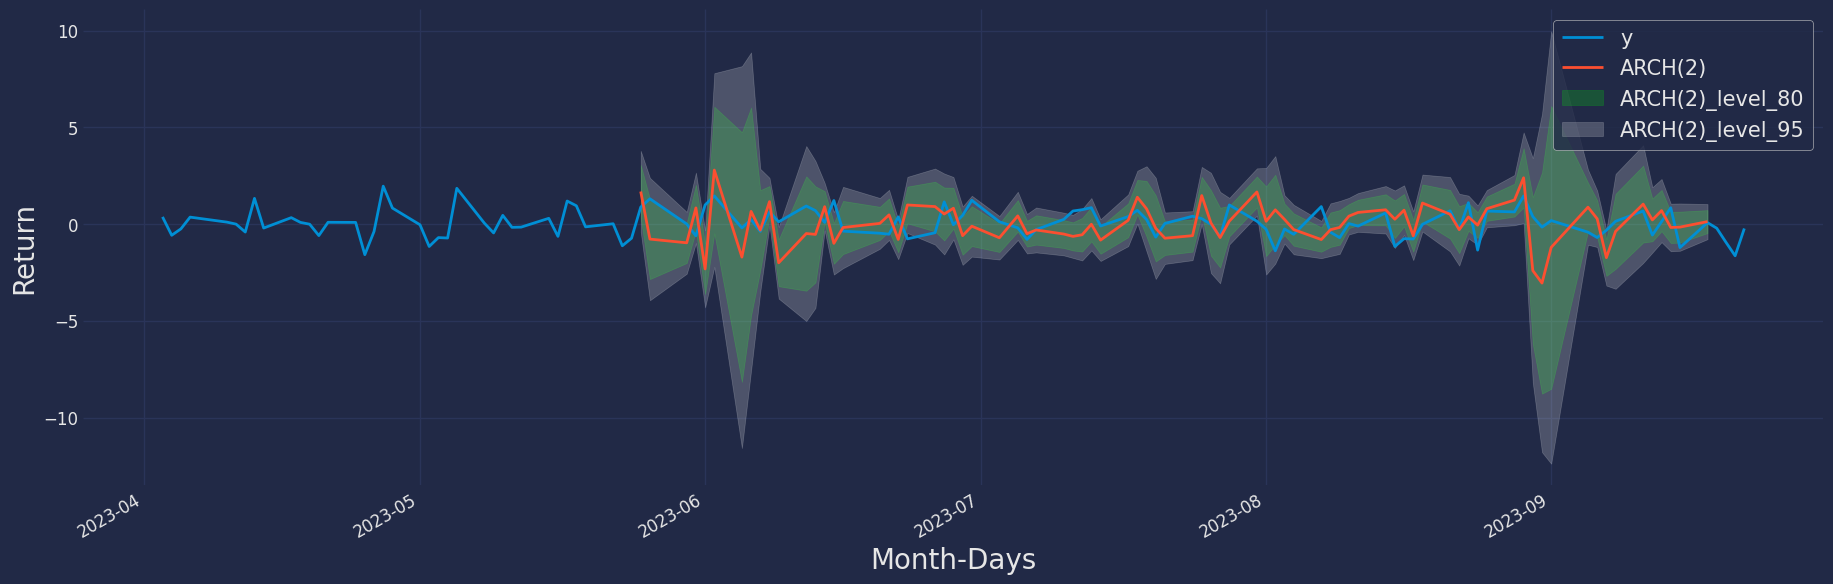

In [40]:
plot_forecasts(train, test, forecast_df, models=["ARCH(2)"])

Let's plot the same graph using the plot function that comes in `Statsforecast`, as shown below.

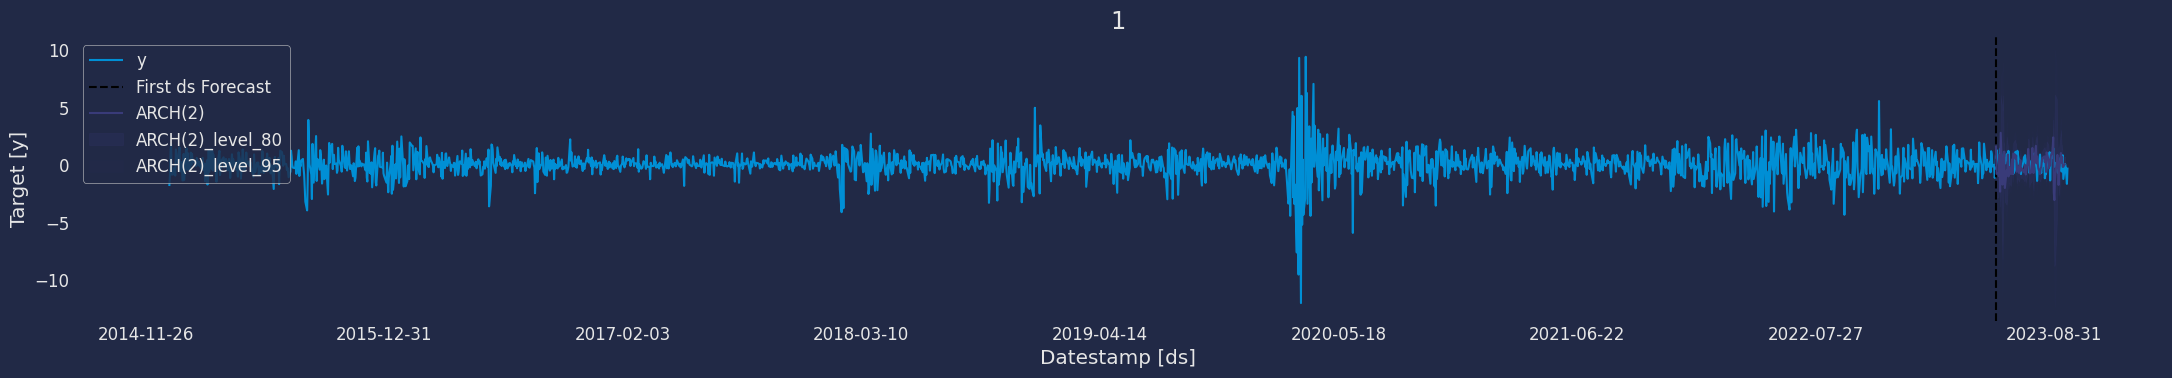

In [41]:
sf.plot(df, forecast_df, level=[80,95])

## Cross-validation <a class="anchor" id="cross_validate"></a>

In previous steps, we’ve taken our historical data to predict the future. However, to asses its accuracy we would also like to know how the model would have performed in the past. To assess the accuracy and robustness of your models on your data perform Cross-Validation.

With time series data, Cross Validation is done by defining a sliding window across the historical data and predicting the period following it. This form of cross-validation allows us to arrive at a better estimation of our model’s predictive abilities across a wider range of temporal instances while also keeping the data in the training set contiguous as is required by our models.

The following graph depicts such a Cross Validation Strategy:

![](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif)

### Perform time series cross-validation

Cross-validation of time series models is considered a best practice but most implementations are very slow. The statsforecast library implements cross-validation as a distributed operation, making the process less time-consuming to perform. If you have big datasets you can also perform Cross Validation in a distributed cluster using Ray, Dask or Spark.

In this case, we want to evaluate the performance of each model for the last 5 months `(n_windows=5)`, forecasting every second months `(step_size=12)`. Depending on your computer, this step should take around 1 min.

The cross_validation method from the StatsForecast class takes the following arguments.

* `df:` training data frame

* `h (int):` represents h steps into the future that are being forecasted. In this case, 12 months ahead.

* `step_size (int):` step size between each window. In other words: how often do you want to run the forecasting processes.

* `n_windows(int):` number of windows used for cross validation. In other words: what number of forecasting processes in the past do you want to evaluate.

In [42]:
crossvalidation_df = sf.cross_validation(df=train,
                                         h=horizon,
                                         step_size=6,
                                         n_windows=5)

The crossvaldation_df object is a new data frame that includes the following columns:

*  `unique_id:` index. If you dont like working with index just run crossvalidation_df.resetindex()
* `ds:` datestamp or temporal index
* `cutoff:` the last datestamp or temporal index for the n_windows.
* `y:` true value
* `"model":` columns with the model’s name and fitted value.

In [43]:
crossvalidation_df

,ds,cutoff,y,ARCH(2)
unique_id,,,,
1,2022-12-27,2022-12-26,0.103734,1.759162
1,2022-12-28,2022-12-26,1.486799,-0.833887
1,2022-12-29,2022-12-26,-1.445170,-0.707878
...,...,...,...,...
1,2023-05-22,2023-01-27,0.015503,-0.176058
1,2023-05-23,2023-01-27,-1.122203,-0.157401
1,2023-05-24,2023-01-27,-0.731860,0.125730


In [44]:
crossvalidation_df.rename(columns = {'y' : 'actual'}, inplace = True) # rename actual values 

cutoff = crossvalidation_df['cutoff'].unique()

for k in range(len(cutoff)): 
    cv = crossvalidation_df[crossvalidation_df['cutoff'] == cutoff[k]]
    StatsForecast.plot(df, cv.loc[:, cv.columns != 'cutoff'])

## Model Evaluation <a class="anchor" id="evaluate"></a>

We can now compute the accuracy of the forecast using an appropiate accuracy metric. Here we’ll use the Root Mean Squared Error (RMSE). To do this, we first need to `install datasetsforecast`, a Python library developed **by Nixtla** that includes a function to compute the RMSE.

In [45]:
%%capture
!pip install datasetsforecast

In [46]:
from datasetsforecast.losses import rmse

The function to compute the RMSE takes two arguments:

1. The actual values.
2. The forecasts, in this case, `ARCH`.

In [47]:
rmse = rmse(crossvalidation_df['actual'], crossvalidation_df["ARCH(2)"])
print("RMSE using cross-validation: ", rmse)

RMSE using cross-validation:  1.5154094


As you have noticed, we have used the cross validation results to perform the evaluation of our model.

Now we are going to evaluate our model with the results of the predictions, we will use different types of metrics MAE, MAPE, MASE, RMSE, SMAPE to evaluate the accuracy.

In [48]:
from datasetsforecast.losses import mae, mape, mase, rmse, smape

In [49]:
def evaluate_performace(y_hist, y_true, y_pred, model):
    y_true = y_true.merge(y_pred, how='left', on=['unique_id', 'ds'])
    evaluation = {}
    evaluation[model] = {}
    for metric in [mase, mae, mape, rmse, smape]:
        metric_name = metric.__name__
        if metric_name == 'mase':
            evaluation[model][metric_name] = metric(y_true['y'].values, 
                                                y_true[model].values, 
                                                y_hist['y'].values, seasonality=12)
        else:
            evaluation[model][metric_name] = metric(y_true['y'].values, y_true[model].values)
    return pd.DataFrame(evaluation).T

In [50]:
evaluate_performace(train, test, Y_hat, model="ARCH(2)")

,mae,mape,mase,rmse,smape
ARCH(2),0.938391,1108.867373,NaN,1.157533,137.060243


## References <a class="anchor" id="references"></a>

1. Changquan Huang • Alla Petukhina. Springer series (2022). Applied Time Series Analysis and Forecasting with Python. 
2. [Engle, R. F. (1982). Autoregressive conditional heteroscedasticity with estimates of the variance of United Kingdom inflation. Econometrica: Journal of the econometric society, 987-1007.](http://www.econ.uiuc.edu/~econ508/Papers/engle82.pdf).
3. [James D. Hamilton. Time Series Analysis Princeton University Press, Princeton, New Jersey, 1st Edition, 1994.](https://press.princeton.edu/books/hardcover/9780691042893/time-series-analysis)
4. [Nixtla Parameters](https://nixtla.github.io/statsforecast/src/core/models.html#arch-model).
5. [Pandas available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).
6. [Rob J. Hyndman and George Athanasopoulos (2018). “Forecasting principles and practice, Time series cross-validation”.](https://otexts.com/fpp3/tscv.html).
7. [Seasonal periods- Rob J Hyndman](https://robjhyndman.com/hyndsight/seasonal-periods/).